In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
from tqdm.notebook import tqdm
from Eearly_stop import *
from sklearn.metrics import roc_auc_score, accuracy_score
import sys
import pandas as pd
import argparse
import os
import warnings
warnings.filterwarnings('ignore')
import math
from torch.utils.data import Dataset, DataLoader
from src_py.cpmix_utils import preprocess_data
from src_py.rhorho import RhoRhoEvent
from src_py.a1a1 import A1A1Event
from src_py.a1rho import A1RhoEvent
from src_py.data_utils import read_np, EventDatasets
from src_py.process_background import convert_bkgd_raw
import train_rhorho, train_a1rho, train_a1a1
from src_py.metrics_utils import calculate_deltas_unsigned, calculate_deltas_signed

# visual libraries
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D 
plt.style.use('ggplot')
# sklearn libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef,classification_report,roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
decaymodes = ['rhorho', 'a1rho', 'a1a1']
types = {"nn_rhorho": train_rhorho.start,"nn_a1rho": train_a1rho.start,"nn_a1a1": train_a1a1.start}
parser = argparse.ArgumentParser(description='Train classifier')

parser.add_argument("--num_classes", dest="NUM_CLASSES", type=int, default=11)
parser.add_argument("-l", "--layers", dest="LAYERS", type=int, help = "number of NN layers", default=6)
parser.add_argument("-s", "--size", dest="SIZE", type=int, help="NN size", default=100)
parser.add_argument("-lambda", "--lambda", type=float, dest="LAMBDA", help="value of lambda parameter", default=0.0)
parser.add_argument("-m", "--method", dest="METHOD", choices=["A", "B", "C"], default="A")
parser.add_argument("-o", "--optimizer", dest="OPT", 
    choices=["GradientDescentOptimizer", "AdadeltaOptimizer", "AdagradOptimizer",
         "ProximalAdagradOptimizer", "AdamOptimizer", "FtrlOptimizer",
         "ProximalGradientDescentOptimizer", "RMSPropOptimizer"], default="AdamOptimizer")
parser.add_argument("-d", "--dropout", dest="DROPOUT", type=float, default=0.0)
parser.add_argument("-e", "--epochs", dest="EPOCHS", type=int, default=3)
# parser.add_argument("-f", "--features", dest="FEAT", help="Features", default="Variant-All")
# #         choices= ["Variant-All", "Variant-1.0", "Variant-1.1", "Variant-2.0", "Variant-2.1",
# #                   "Variant-2.2", "Variant-3.0", "Variant-3.1", "Variant-4.0", "Variant-4.1"])

########### Change this to according dir to download data #######################
parser.add_argument("-i", "--input", dest="IN", default='/home/anderson/higgs_data/rhorho')

parser.add_argument("--miniset", dest="MINISET", type=lambda s: s.lower() in ['true', 't', 'yes', '1'], default=False)
parser.add_argument("--z_noise_fraction", dest="Z_NOISE_FRACTION", type=float, default=0.0)

parser.add_argument("--delt_classes", dest="DELT_CLASSES", type=int, default=0,
                    help='Maximal distance between predicted and valid class for event being considered as correctly classified')

parser.add_argument("--unweighted", dest="UNWEIGHTED", type=lambda s: s.lower() in ['true', 't', 'yes', '1'], default=False)
parser.add_argument("--reuse_weights", dest="REUSE_WEIGHTS", type=bool, default=False)
parser.add_argument("--restrict_most_probable_angle", dest="RESTRICT_MOST_PROBABLE_ANGLE", type=bool, default=False)
parser.add_argument("--force_download", dest="FORCE_DOWNLOAD", type=bool, default=False)
parser.add_argument("--normalize_weights", dest="NORMALIZE_WEIGHTS", type=bool, default=False)


parser.add_argument("--beta",  type=float, dest="BETA", help="value of beta parameter for polynomial smearing", default=0.0)
parser.add_argument("--pol_b", type=float, dest="pol_b", help="value of b parameter for polynomial smearing", default=0.0)
parser.add_argument("--pol_c", type=float, dest="pol_c", help="value of c parameter for polynomial smearing", default=0.0)

parser.add_argument("--w1", dest="W1")
parser.add_argument("--w2", dest="W2")
parser.add_argument("--f", dest="FEAT", default="Variant-All")
parser.add_argument("--plot_features", dest="PLOT_FEATURES", choices=["NO", "FILTER", "NO-FILTER"], default="NO")
parser.add_argument("--training_method", dest="TRAINING_METHOD", choices=["soft_weights", "soft_c012s",  "soft_argmaxs", "regr_c012s", "regr_weights", "regr_argmaxs"], default="soft_weights")
parser.add_argument("--hits_c012s", dest="HITS_C012s", choices=["hits_c0s", "hits_c1s",  "hits_c2s"], default="hits_c0s")

######Change this to according type (rhorho, a1rho, a1a1)#######################
parser.add_argument("-t", "--type", dest="TYPE", choices=types.keys(), default='nn_rhorho')

parser.add_argument("-r", "--reprocess", dest="REPRO", type=bool, default=False)
parser.add_argument("-bkgd", "--bkgdpath", dest="BKGDPATH", default='/home/anderson/Ztt_raw/pythia.Z_115_135.%s.1M.*.outTUPLE_labFrame')
parser.add_argument("--label", dest="LABEL", default=True)

args, unknown = parser.parse_known_args()

### Preprocessing singal and bkgd data

In [3]:
events={'nn_rhorho':'RhoRhoEvent', 'nn_a1rho':'A1RhoEvent', 'nn_a1a1':'A1A1Event'}
if args.REPRO:
    for decaymode in tqdm(decaymodes):
        points = []
        args.Z_FRACTION = 1.0
        args.IN = '/home/anderson/higgs_data/'+decaymode
        args.TYPE = 'nn_'+decaymode
        args.LABEL = False
        data, weights, argmaxs, perm, c012s, hits_argmaxs, hits_c012s = preprocess_data(args)
        event = eval(events[args.TYPE])(data, args)
        points.append(EventDatasets(event, weights, argmaxs, perm, c012s=c012s, hits_argmaxs=hits_argmaxs,  hits_c012s=hits_c012s, miniset=args.MINISET, unweighted=args.UNWEIGHTED))
        pickle.dump(points,open(args.IN+'/events_w_background_test.pk','wb'))
        break

### Loading preprocessed signal and bkgd data

In [4]:
background_points=pickle.load(open(args.IN+'/events_w_background_test.pk','rb'))

In [5]:
particle_idx = 0 # 0 for rhorho
background=[]
background.append(background_points[particle_idx].train.x[background_points[particle_idx].train.weights.sum(axis=1)==0])
background.append(background_points[particle_idx].valid.x[background_points[particle_idx].valid.weights.sum(axis=1)==0])
background.append(background_points[particle_idx].test.x[background_points[particle_idx].test.weights.sum(axis=1)==0])

In [6]:
background=np.concatenate(background)
background.reshape(1000000,24)

array([[-0.19831094, -0.49839373,  1.06170676, ..., -1.13773675,
         0.85293578,  0.85284798],
       [-0.79935417,  0.60772346,  0.77437359, ...,  0.83942294,
         0.28191948,  0.28190085],
       [-2.66754798,  1.76056837, -2.2107468 , ...,  0.56311519,
         0.77091411,  0.77073434],
       ...,
       [ 1.09235274,  0.58649809, -0.41574734, ..., -1.11866907,
         1.18517997,  1.18514322],
       [-0.28748871, -0.09970903,  1.09974832, ...,  0.82841946,
         3.46677281,  3.46719197],
       [ 1.80826652, -0.91936072, -1.45806182, ...,  0.90395801,
         1.00589818,  1.00580252]])

In [7]:
particle_idx = 0 # 0 for rhorho
signal=[]
signal.append(background_points[particle_idx].train.x[background_points[particle_idx].train.weights.sum(axis=1)!=0])
signal.append(background_points[particle_idx].valid.x[background_points[particle_idx].valid.weights.sum(axis=1)!=0])
signal.append(background_points[particle_idx].test.x[background_points[particle_idx].test.weights.sum(axis=1)!=0])

In [8]:
signal=np.concatenate(signal)
signal.reshape(1000000,24)

array([[-1.14086669,  0.19679849,  0.58942567, ..., -1.06073192,
        -0.34897211, -0.34908758],
       [ 1.6980422 , -1.27714402, -0.74419418, ...,  0.48465869,
        -1.26164328, -1.2617843 ],
       [ 0.59833487, -1.86839381, -0.8245309 , ..., -0.862427  ,
        -1.07679274, -1.07674796],
       ...,
       [ 1.32113359,  0.10640537,  0.22537583, ..., -0.54896391,
        -1.01916207, -1.01948847],
       [-0.23959493, -0.25177192,  1.10606364, ...,  1.57362902,
        -0.41138465, -0.41146726],
       [-1.38219461,  1.83690788, -1.22797047, ..., -1.57476317,
        -0.07203461, -0.07212968]])

### Plot feature distributions

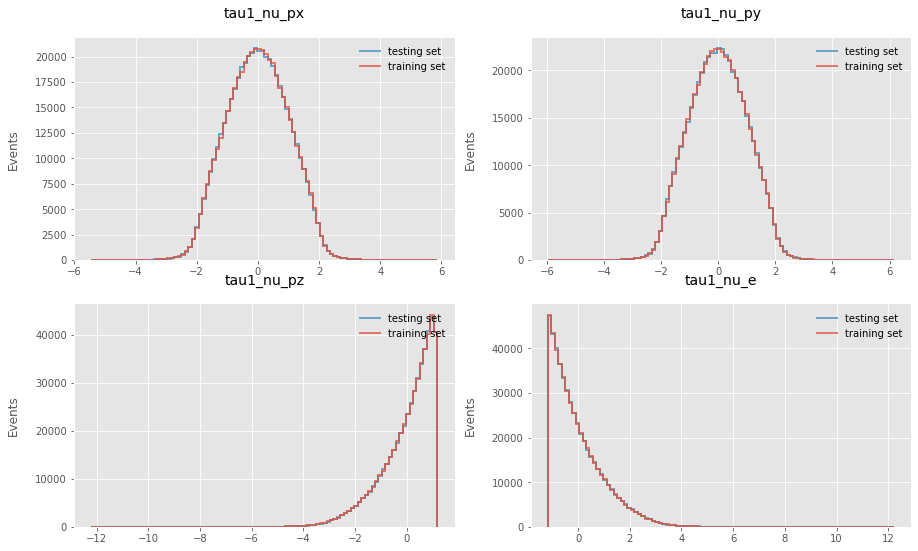

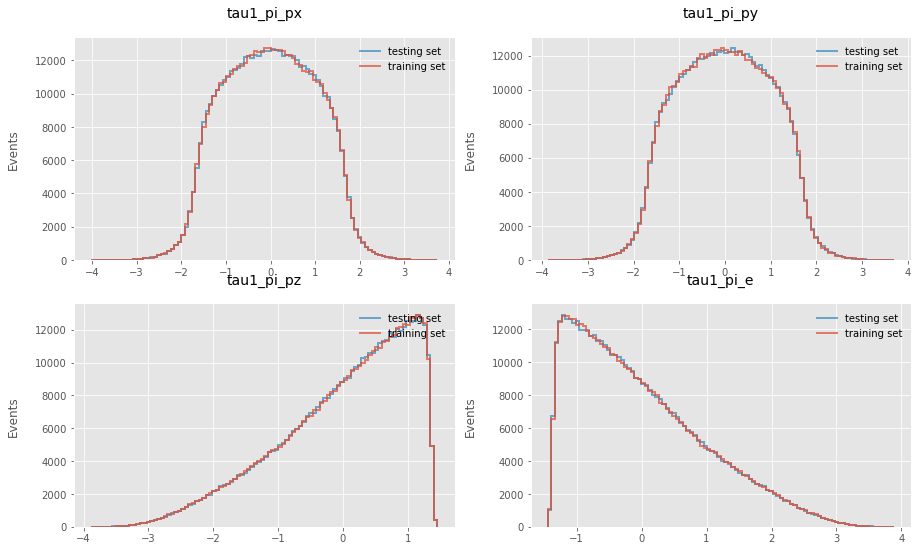

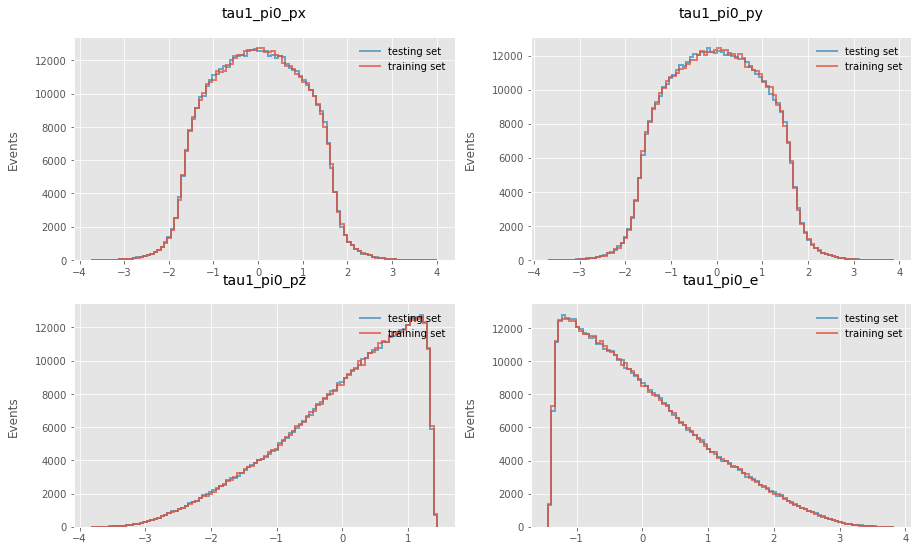

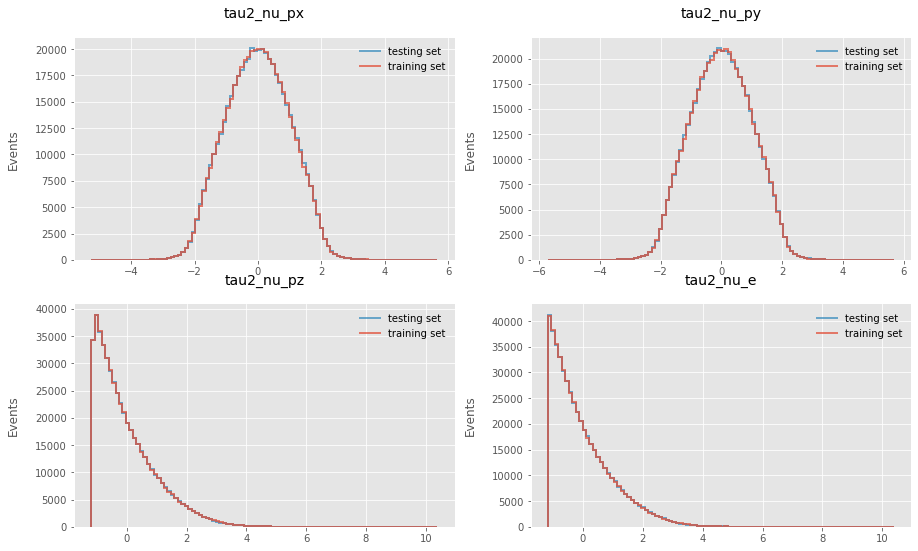

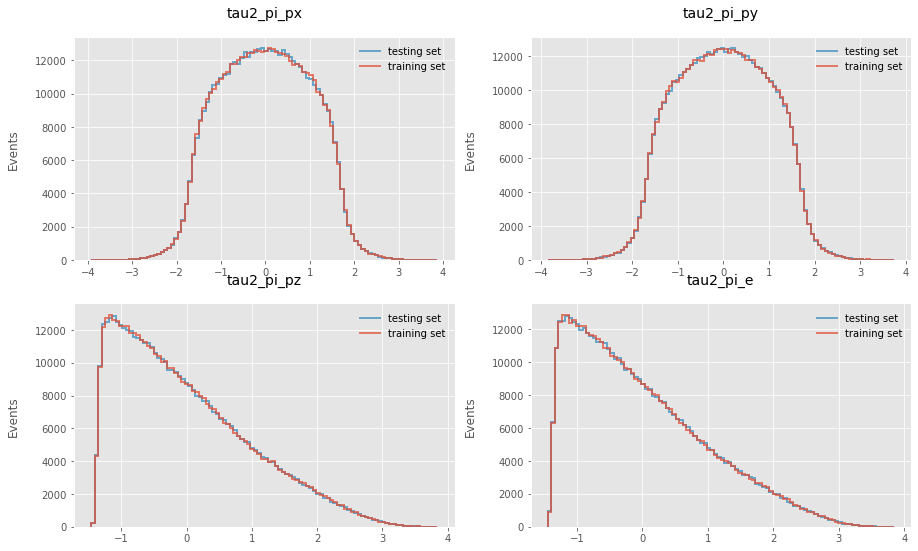

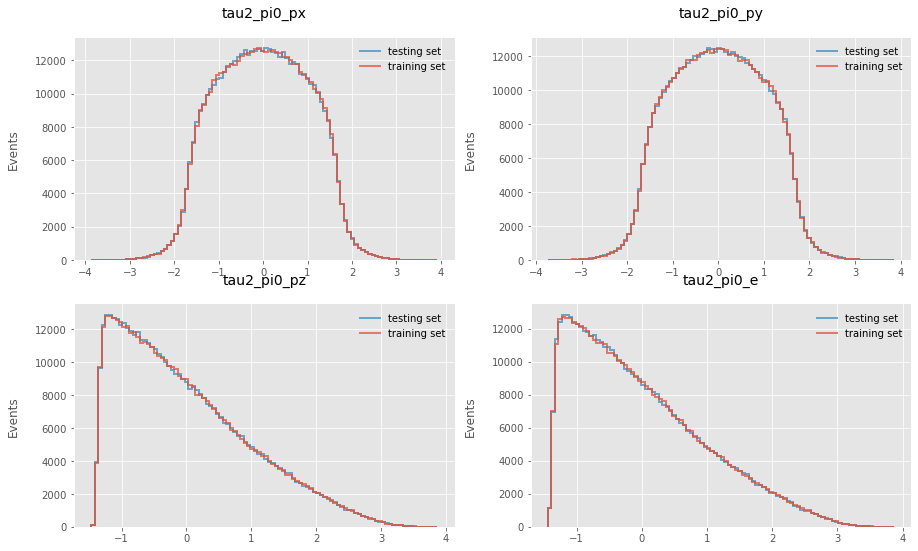

In [9]:
## comparing training set and testing set
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

features = ["tau1_nu_px", "tau1_nu_py", "tau1_nu_pz", "tau1_nu_e",
            "tau1_pi_px", "tau1_pi_py", "tau1_pi_pz", "tau1_pi_e", "tau1_pi0_px", "tau1_pi0_py", "tau1_pi0_pz", "tau1_pi0_e",
            "tau2_nu_px", "tau2_nu_py", "tau2_nu_pz", "tau2_nu_e",
            "tau2_pi_px", "tau2_pi_py", "tau2_pi_pz", "tau2_pi_e", "tau2_pi0_px", "tau2_pi0_py", "tau2_pi0_pz", "tau2_pi0_e"]

bkgd_train=background[0:500000]
bkgd_test=background[500000:1000000]

for k in range(0,6):
    fig, ax = plt.subplots(2, 2, figsize=(15,9))
    for j in range(0,4):
        # Create figure with 'step' type of histogram to improve plot readability
        ax[j//2, j%2].hist([bkgd_train[:,j+k*4], bkgd_test[:,j+k*4]], bins=100, histtype='step', linewidth=2,
                alpha=0.7, label=['training set','testing set'])
        
        # Edit legend to get lines as legend keys instead of the default polygons
        # and sort the legend entries in alphanumeric order
        handles, labels = ax[j//2, j%2].get_legend_handles_labels()
        leg_entries = {}
        for h, label in zip(handles, labels):
            leg_entries[label] = Line2D([0], [0], color=h.get_facecolor()[:-1],
                                        alpha=h.get_alpha(), lw=h.get_linewidth())
        labels_sorted, lines = zip(*sorted(leg_entries.items()))
        ax[j//2, j%2].legend(lines, labels_sorted, frameon=False)

        # Remove spines
        ax[j//2, j%2].spines['top'].set_visible(False)
        ax[j//2, j%2].spines['right'].set_visible(False)

        # Add annotations
        #plt.ylabel('Events', labelpad=15)
        #plot_title='Ztt '+features[j]+' distribution'
        #plt.title(plot_title, fontsize=14, pad=20)
        ax[j//2, j%2].set_ylabel('Events', labelpad=15)
        ax[j//2, j%2].set_title(features[j+k*4], fontsize=14, pad=20)
        
    plt.show()

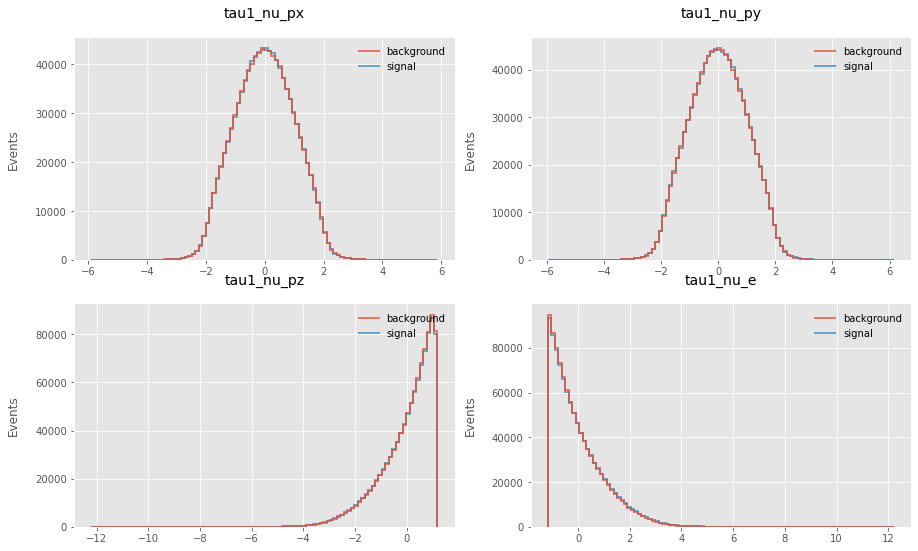

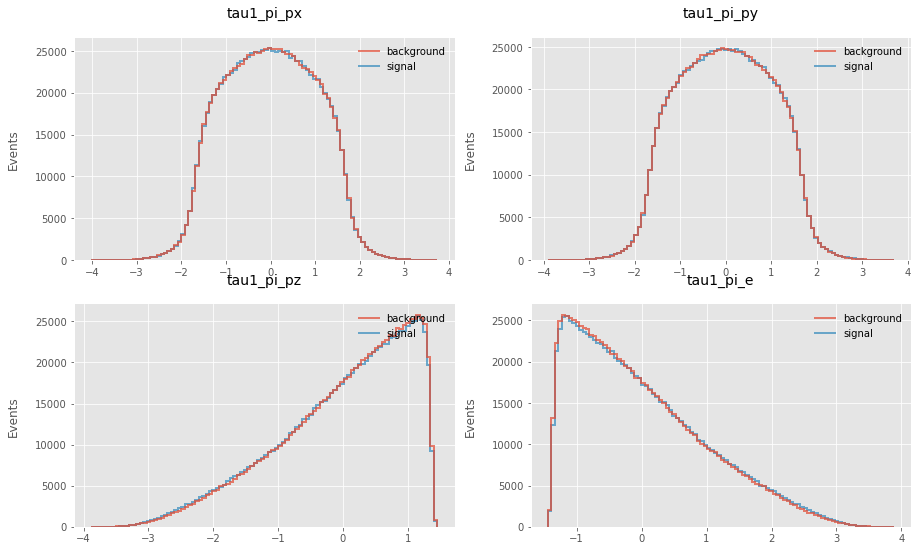

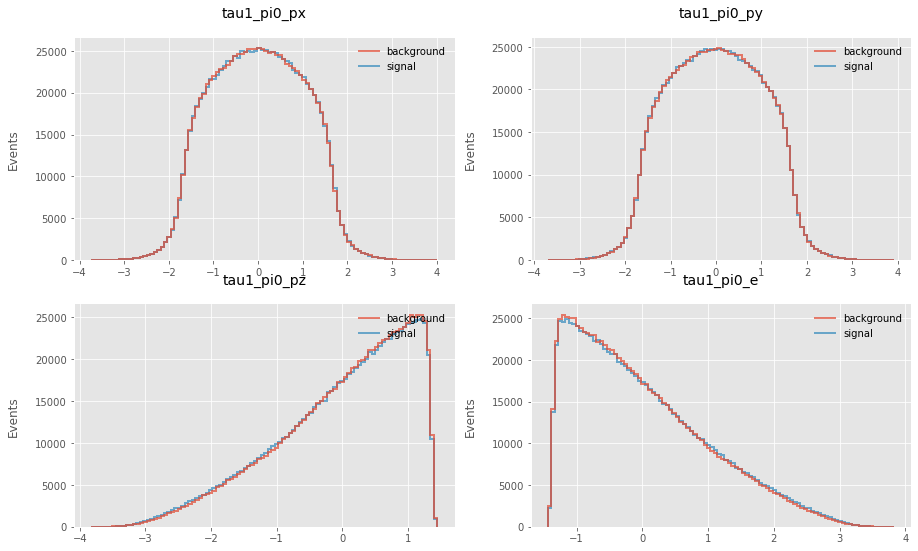

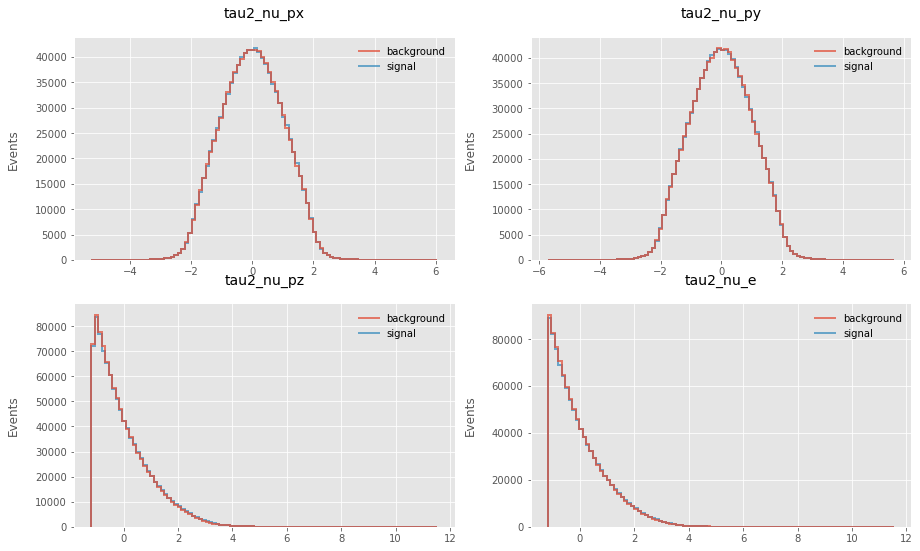

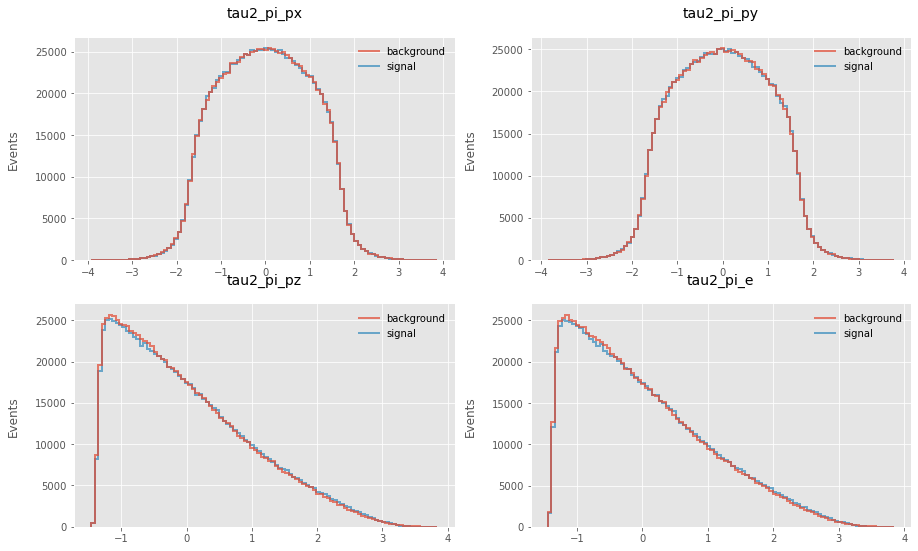

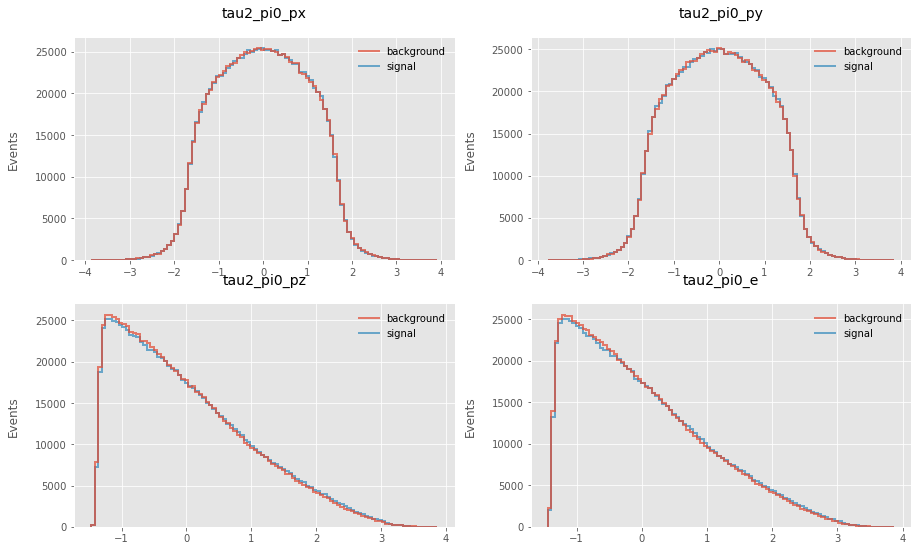

In [10]:
## comparing signal and background
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

features = ["tau1_nu_px", "tau1_nu_py", "tau1_nu_pz", "tau1_nu_e",
            "tau1_pi_px", "tau1_pi_py", "tau1_pi_pz", "tau1_pi_e", "tau1_pi0_px", "tau1_pi0_py", "tau1_pi0_pz", "tau1_pi0_e",
            "tau2_nu_px", "tau2_nu_py", "tau2_nu_pz", "tau2_nu_e",
            "tau2_pi_px", "tau2_pi_py", "tau2_pi_pz", "tau2_pi_e", "tau2_pi0_px", "tau2_pi0_py", "tau2_pi0_pz", "tau2_pi0_e"]

bkgd_train=background[0:1000000]
signal_train=signal[0:1000000]

for k in range(0,6):
    fig, ax = plt.subplots(2, 2, figsize=(15,9))
    for j in range(0,4):
        # Create figure with 'step' type of histogram to improve plot readability
        ax[j//2, j%2].hist([bkgd_train[:,j+k*4], signal_train[:,j+k*4]], bins=100, histtype='step', linewidth=2,
                alpha=0.7, label=['background','signal'])
        
        # Edit legend to get lines as legend keys instead of the default polygons
        # and sort the legend entries in alphanumeric order
        handles, labels = ax[j//2, j%2].get_legend_handles_labels()
        leg_entries = {}
        for h, label in zip(handles, labels):
            leg_entries[label] = Line2D([0], [0], color=h.get_facecolor()[:-1],
                                        alpha=h.get_alpha(), lw=h.get_linewidth())
        labels_sorted, lines = zip(*sorted(leg_entries.items()))
        ax[j//2, j%2].legend(lines, labels_sorted, frameon=False)

        # Remove spines
        ax[j//2, j%2].spines['top'].set_visible(False)
        ax[j//2, j%2].spines['right'].set_visible(False)

        # Add annotations
        #plt.ylabel('Events', labelpad=15)
        #plot_title='Ztt '+features[j]+' distribution'
        #plt.title(plot_title, fontsize=14, pad=20)
        ax[j//2, j%2].set_ylabel('Events', labelpad=15)
        ax[j//2, j%2].set_title(features[j+k*4], fontsize=14, pad=20)
        
    plt.show()

In [11]:
df_background = pd.DataFrame(background)
particle_name = ['tau1_nu', 'tau1_pi-', 'tau1_pi0', 'tau2_nu', 'tau2_pi+', 'tau2_pi0']
df_background.columns = pd.MultiIndex.from_arrays([sum([[x]*4 for x in particle_name],[]), ['p_x', 'p_y', 'p_z', 'E']*6])

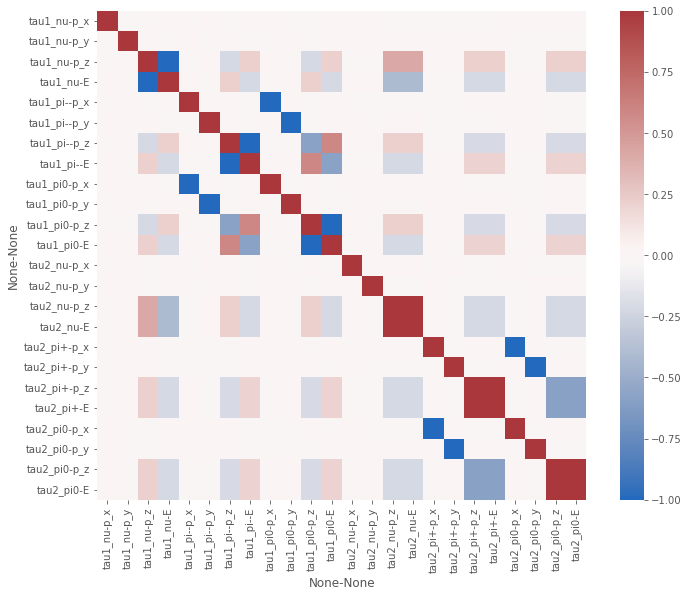

In [12]:
# heat map of correlation of features
correlation_matrix = df_background.corr()
fig = plt.figure(figsize=(12,9))
sns.heatmap(correlation_matrix,cmap="vlag",square = True, vmin = -1.0, vmax = 1.0)
plt.show()

In [13]:
df_signal = pd.DataFrame(signal)
df_signal.columns = pd.MultiIndex.from_arrays([sum([[x]*4 for x in particle_name],[]), ['p_x', 'p_y', 'p_z', 'E']*6])

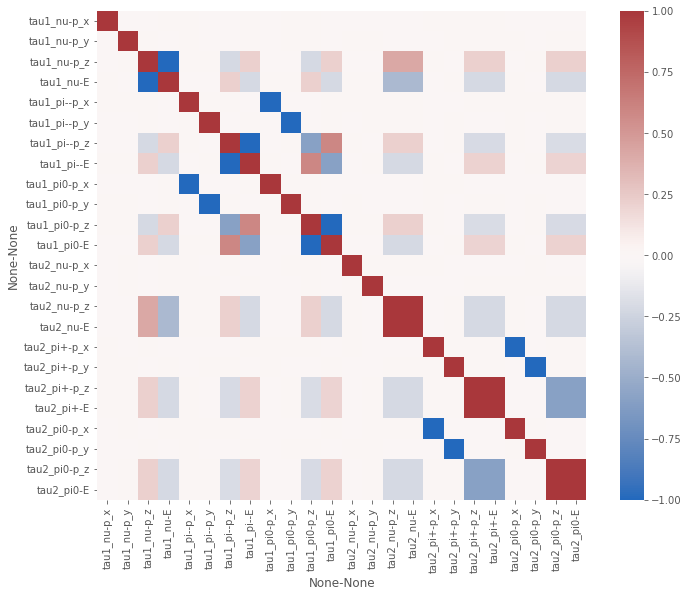

In [14]:
# heat map of correlation of features
correlation_matrix = df_signal.corr()
fig = plt.figure(figsize=(12,9))
sns.heatmap(correlation_matrix,cmap="vlag",square = True, vmin = -1.0, vmax = 1.0)
plt.show()

### Loading raw signal and bkgd data

In [15]:
raw_Htt = np.load("/home/anderson/higgs_data/rhorho/rhorho_raw.data.npy")
raw_Ztt = np.load("/home/anderson/higgs_data/rhorho/rhorhoZ_raw.data.npy")
df_Htt = pd.DataFrame(raw_Htt)
df_Ztt = pd.DataFrame(raw_Ztt)

In [16]:
df_Htt.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,2.816050,-4.370471,3.219078,6.115040,16.0,9.202453,-12.449674,11.851361,19.497532,-211.0,...,12.849713,76.012524,309.442587,318.900852,211.0,1.817029,11.847960,46.472940,47.994043,111.0
1,-7.862551,-20.456146,-17.542083,28.071309,16.0,-3.918373,-11.140151,-9.458138,15.130515,-211.0,...,17.967301,18.721119,-33.943319,42.725549,211.0,13.137073,13.335026,-25.479927,31.617250,111.0
2,50.377066,10.793155,-459.164888,462.046248,16.0,9.152734,1.895034,-87.637855,88.134991,-211.0,...,-5.264416,-0.649004,-50.045222,50.325729,211.0,-42.784525,-7.722810,-396.875696,399.249914,111.0
3,3.039177,-8.879409,5.658697,10.959081,16.0,14.876561,-54.773805,35.501200,66.946520,-211.0,...,-1.350398,4.724976,-0.816164,4.983430,211.0,-1.284403,6.451963,-0.347639,6.589126,111.0
4,10.339023,-25.463651,27.163674,38.641405,16.0,2.088692,-4.456842,4.130246,6.426857,-211.0,...,-11.123746,-1.343838,11.862252,16.317970,211.0,-86.470829,-8.777015,91.401529,126.128895,111.0


In [17]:
df_Ztt.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,4.397278,-1.387607,14.400189,15.120418,16.0,47.984630,-9.818669,156.271567,163.767375,-211.0,...,-5.747717,1.427523,-1.382287,6.083113,211.0,-8.259308,2.672198,-2.327183,8.988371,111.0
1,0.576789,-1.189591,0.021883,1.322267,16.0,24.656559,-31.756384,-0.421931,40.207106,-211.0,...,-12.174363,15.803821,92.878228,94.996635,211.0,-2.684236,4.099022,22.581910,23.107747,111.0
2,-2.285024,-1.154328,9.218806,9.567669,16.0,-27.382297,-13.407077,93.969664,98.791989,-211.0,...,33.481431,3.729773,496.255254,497.397440,211.0,4.680195,0.478709,68.554213,68.715586,111.0
3,-30.589355,2.651237,61.726002,68.940824,16.0,-26.158419,3.502478,54.860332,60.878615,-211.0,...,16.208369,-0.669791,26.802989,31.330170,211.0,15.312360,-1.153436,26.398174,30.539820,111.0
4,0.145831,-0.066449,-0.169235,0.233287,16.0,21.558883,-4.161389,-33.340873,39.921622,-211.0,...,-9.196051,1.133152,-13.104259,16.049688,211.0,-44.191889,5.545682,-64.882074,78.698026,111.0


In [18]:
df_Htt.drop(columns=[4,9,14,19,24,29],inplace=True)

In [19]:
df_Ztt.drop(columns=[4,9,14,19,24,29],inplace=True)

In [20]:
particle_name = ['tau1_nu', 'tau1_pi-', 'tau1_pi0', 'tau2_nu', 'tau2_pi+', 'tau2_pi0']
df_Htt.columns = pd.MultiIndex.from_arrays([sum([[x]*4 for x in particle_name],[]), ['p_x', 'p_y', 'p_z', 'E']*6])
df_Ztt.columns = pd.MultiIndex.from_arrays([sum([[x]*4 for x in particle_name],[]), ['p_x', 'p_y', 'p_z', 'E']*6])

In [21]:
# distribution of anomalous features
features = df_Htt.iloc[:,0:24].columns
features

MultiIndex([( 'tau1_nu', 'p_x'),
            ( 'tau1_nu', 'p_y'),
            ( 'tau1_nu', 'p_z'),
            ( 'tau1_nu',   'E'),
            ('tau1_pi-', 'p_x'),
            ('tau1_pi-', 'p_y'),
            ('tau1_pi-', 'p_z'),
            ('tau1_pi-',   'E'),
            ('tau1_pi0', 'p_x'),
            ('tau1_pi0', 'p_y'),
            ('tau1_pi0', 'p_z'),
            ('tau1_pi0',   'E'),
            ( 'tau2_nu', 'p_x'),
            ( 'tau2_nu', 'p_y'),
            ( 'tau2_nu', 'p_z'),
            ( 'tau2_nu',   'E'),
            ('tau2_pi+', 'p_x'),
            ('tau2_pi+', 'p_y'),
            ('tau2_pi+', 'p_z'),
            ('tau2_pi+',   'E'),
            ('tau2_pi0', 'p_x'),
            ('tau2_pi0', 'p_y'),
            ('tau2_pi0', 'p_z'),
            ('tau2_pi0',   'E')],
           )

In [22]:
df_Ztt = df_Ztt.truncate(after=999999)

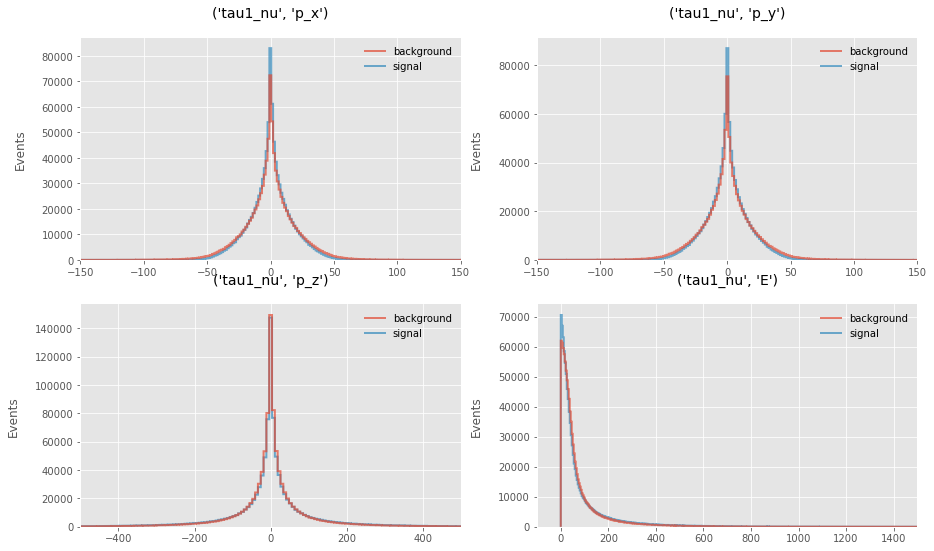

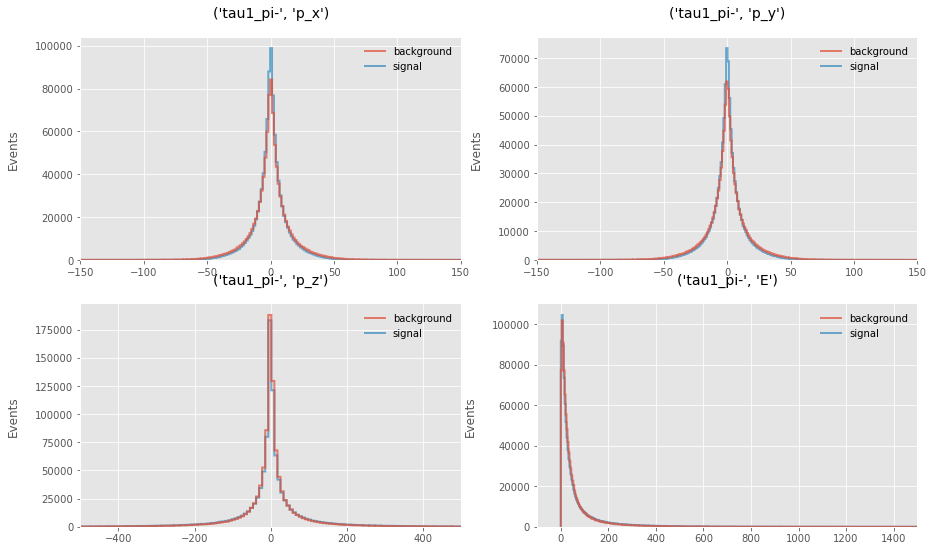

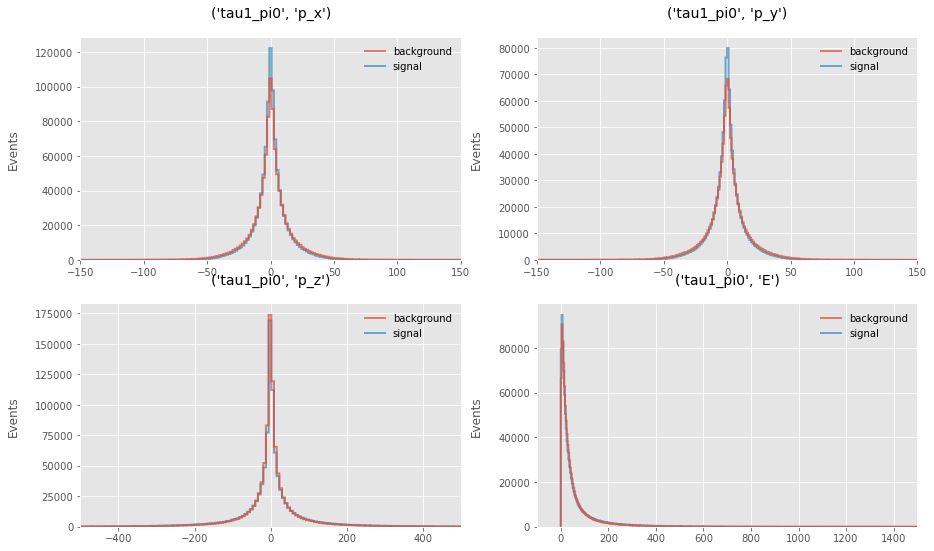

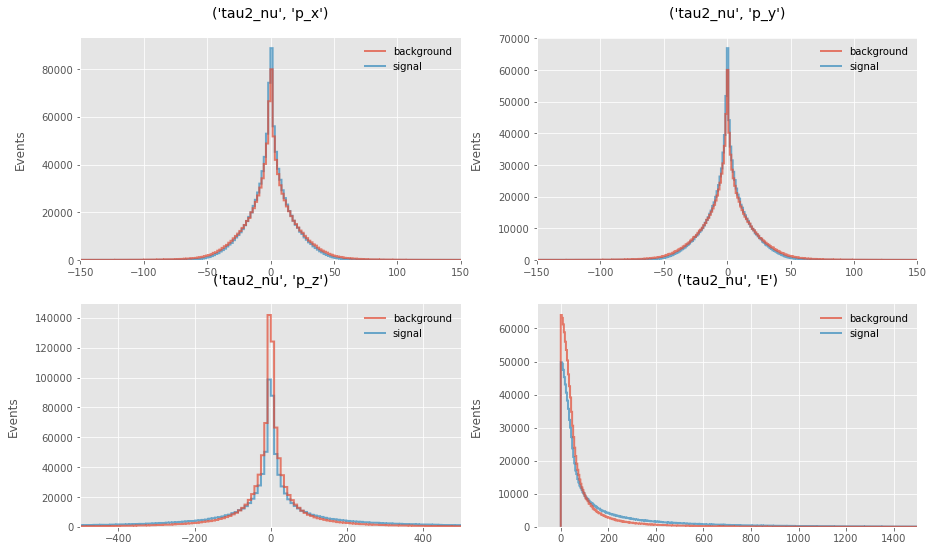

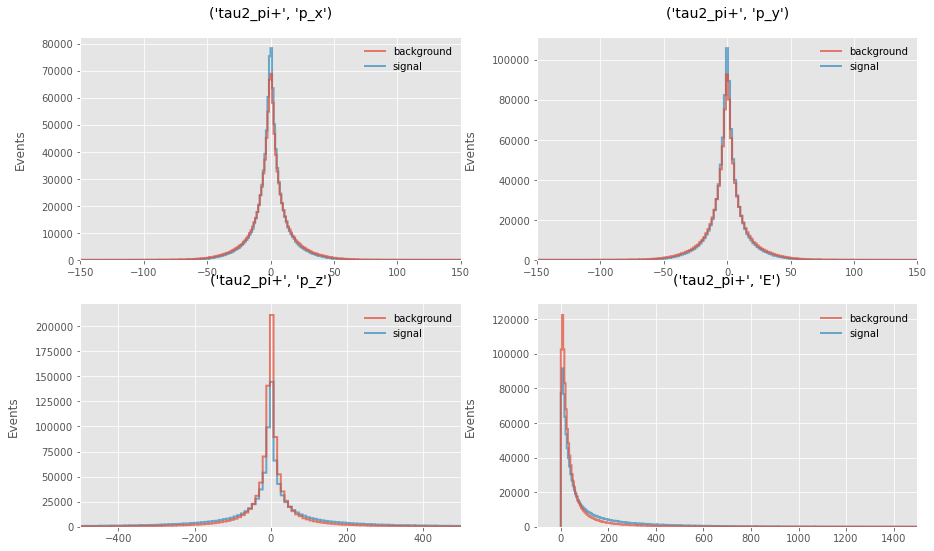

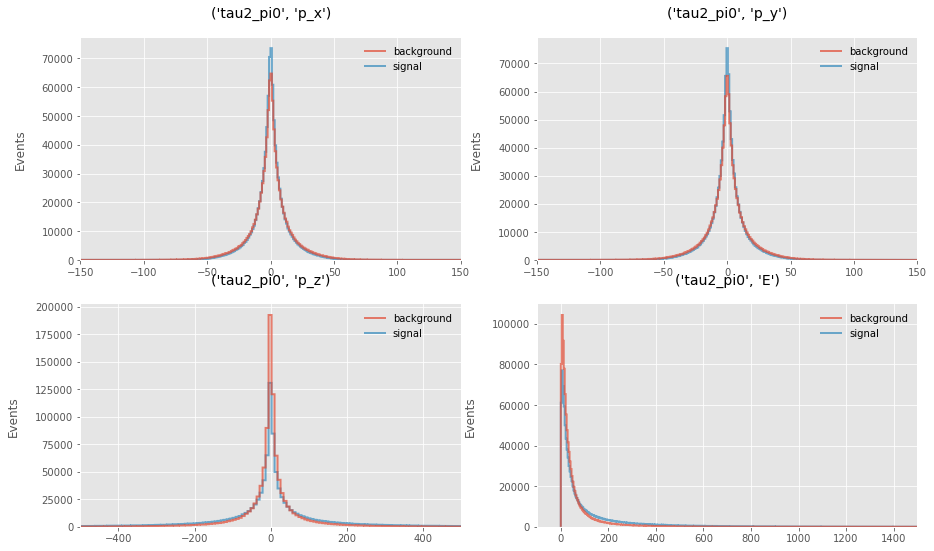

In [23]:
from matplotlib.lines import Line2D

for k in range(0,6):
    fig, ax = plt.subplots(2, 2, figsize=(15,9))
    for j in range(0,4):
        # Create figure with 'step' type of histogram to improve plot readability
        ax[j//2, j%2].hist([df_Htt[features[j+k*4]], df_Ztt[features[j+k*4]]], bins=1000, histtype='step', linewidth=2,
                alpha=0.7, label=['background','signal'])
        
        # Edit legend to get lines as legend keys instead of the default polygons
        # and sort the legend entries in alphanumeric order
        handles, labels = ax[j//2, j%2].get_legend_handles_labels()
        leg_entries = {}
        for h, label in zip(handles, labels):
            leg_entries[label] = Line2D([0], [0], color=h.get_facecolor()[:-1],
                                        alpha=h.get_alpha(), lw=h.get_linewidth())
        labels_sorted, lines = zip(*sorted(leg_entries.items()))
        ax[j//2, j%2].legend(lines, labels_sorted, frameon=False)

        # Remove spines
        ax[j//2, j%2].spines['top'].set_visible(False)
        ax[j//2, j%2].spines['right'].set_visible(False)

        # Add annotations
        #plt.ylabel('Events', labelpad=15)
        #plot_title='Ztt '+features[j]+' distribution'
        #plt.title(plot_title, fontsize=14, pad=20)
        ax[j//2, j%2].set_ylabel('Events', labelpad=15)
        ax[j//2, j%2].set_title(features[j+k*4], fontsize=14, pad=20)
        
    ax[0,0].set_xlim([-150, 150])
    ax[0,1].set_xlim([-150, 150])
    ax[1,0].set_xlim([-500, 500])
    ax[1,1].set_xlim([-100, 1500])
    
    plt.show()


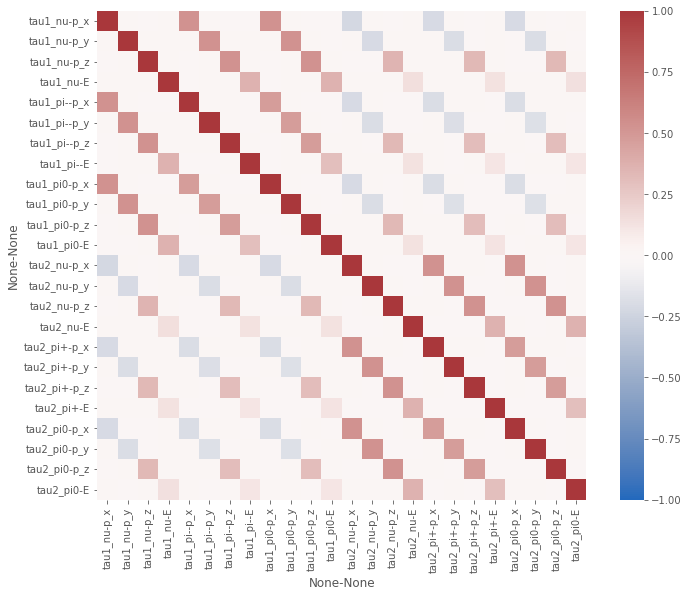

In [24]:
# heat map of correlation of features
correlation_matrix = df_Htt.corr()
fig = plt.figure(figsize=(12,9))
sns.heatmap(correlation_matrix,cmap="vlag",square = True, vmin = -1.0, vmax = 1.0)
plt.show()

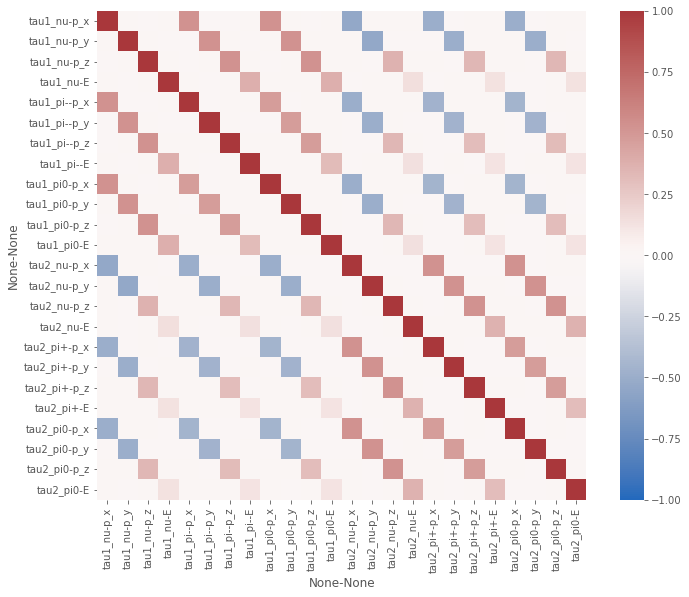

In [25]:
# heat map of correlation of features
correlation_matrix = df_Ztt.corr()
fig = plt.figure(figsize=(12,9))
sns.heatmap(correlation_matrix,cmap="vlag",square = True, vmin = -1.0, vmax = 1.0)
plt.show()